

# Analysing how Socio-demographic and Economic Factors Affect Household Housing Expenditure in New York

## Motivation
Given that housing is perhaps the single most costly expenditure item that a household in the United States is paying for, housing affordability is a very relevant and pertinent issue. According to a paper by [Quigley and Raphael, 2004](https://journals.sagepub.com/doi/full/10.1177/0042098015572529#), most poor and near-poor families often devote up to half their income to housing. This seems to indicate that the amount of money a household spends on housing appears to be affected by the total income earned by that household. Additionally, it may also indicate an inequality of housing affordability across different households according to their economic class. 

There is a large demand for the supply of affordable housing to households of all income levels but due to factors ranging from income inequality to racism or political injustice, such as a supply is often not available in many US cities and states [Ben-Shahar and Warszawski, 2015](https://journals.sagepub.com/doi/full/10.1177/0042098015572529).


In this data analysis, I wish to explore if and how socio-demographic and economic factors corellate with housing expenditure across different households located in New York city. 

The reason I chose New York is two-fold. Firstly, according to the [Economic Policy Institute](https://www.epi.org/publication/the-new-gilded-age-income-inequality-in-the-u-s-by-state-metropolitan-area-and-county/), New York is the state with the most income inequality as of 2015. Secondly, in the data that I analyse, New York has approximately 100,000 observations which are enough for exercising sampling methedoogy. I am also confident that households from every economic class are well represented. 


## Data

The data I use is from the 2013 version of the American Community Survey which surveys over 3.5 million households about different socio-demographic  characteristics across the United States. The data details locational and dwelling unit characteristic, socio-demographic and economic characteristics of those living in the households. Link to [data](https://www2.census.gov/acs2013_1yr/pums/) and to [data dictionary](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict13.txt).

Although I do not have an extensive background in economics or public policy, by conducting a literature review, I have chosen among more than 600 variables, to consider these socio-demographic and economic characteristics (column names in quotations):  

* Total annual income 'HINCP'
* Family status (married or single) 'WKEXREL'
* Household working status (working fulltime or not) 'WKEXREL'
* Number of income providers 'NP'

Note: 'WKEXREL' column values are encoded in such a way as to provide data about both family status and working status. 

I have chosen these in hopes of segmenting or stratifying housing expenditure and cost, and perhaps finding a corellation between any number of these characteristics with housing expenditures.

The variables I am using to quantify housing expenditure are: 

* Total value of property for non-rented houses 'VALP' (fully owned or morgaged) 
* Monthly rent for rented houses 'GRNTP'
* Utility bills for electricity, gas and water.'ELEP', 'GASP', 'WATP'
* Selected Monthly Ownership Costs for non-rented houses (include morgage costs, contracts to purchase, home equity loans etc.) 'SMOCP'

## Questions

I further explore affordability among populations stratified by socio-economic and demographic characteristics. Examples of questions I wish to explore: 
* How skewed or symmetric is the distribution of value of properties in New York? 
* How skewed or symmetric is the distribution of monthly household income? Is that a reflection of income inequality? 
* How does, if at all, monthly household income corellate to the value of property if property is owned, or gross monthly rent if property is not owned. 
* Which variable is monthly household income most corellated? 
* Does monthly electricity cost corellate with houshold monthy income? 


## Ethical Concerns

* Some of the stakeholders of this data include but not limited to: 
  * Families living in the United States
  * Politicians involved with the housing sector
  * Large business corporations centered around housing such as renting or selling residential houses
* These stakeholders would each have interest in acquiring the results of a study like this. However, their interests and goals may be in conflict. For example: 
  *  Politicians may use the results of such a study to better direct their attention as it relates to policy making. Perhaps better policies can be made to bridge the disparity between the different economic classes of New York. 
  * Large corporations may take advantage of the results of such a study by creating prices that are more attractive to households of higher economic classes. 


# Loading data from tabular form

### Importing Libraries

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

Columns I use
* Type of property 'TYPE' (house or group quarters)
* Total annual income 'HINCP'
* Householder working and family status 'WKEXREL'
* Number of persons in household 'NP' 
* Value of property (fully owned or morgaged) 'VALP'
* Gross monthly rent (rented houses) 'GRNTP' 
* Selected monthly owner costs 'SMOCP'
* Total monthly cost, electricity 'ELEP', 
* Total monthly cost, gas 'GASP'
* Total annual cost, water 'WATP'

In [114]:
#choosing which columns to use
fields = ['TYPE', 'HINCP', 'WKEXREL', 'NP', 'VALP', 'GRNTP', 'SMOCP', 'ELEP', 'GASP', 'WATP']
new_york = pd.read_csv("/content/ss13hny.csv",  usecols=fields)
new_york.head()
print(f"Total observations of data:", new_york.shape[0], "Total columns:", new_york.shape[1])

Total observations of data: 92085 Total columns: 10


## Data Preprocessing and Cleaning

### Filtering observations

* I filter out all vacant spaces specified by 'NP' (Number of persons) equalling 0. 
* The data itself is divided by the variable 'TYPE' into 'housing units' and 'group quarters.' Group quarters represent exceptional living circumstances and for the purpose of this study I filter them out. 
* There are some outliers that greatly positively skew the 'HINCP' (total annual household income) distribution. This is mainly caused by households with very high income which constitute less that 0.1% of the data. I use standard methods to filter outliers by filtering out data that is greater than 1.5 times the interquartile range.  
* In total 22, 531 observations are filtered by the above methods


In [115]:
#Filtering observations
housing = new_york[(new_york["TYPE"] == 1) & ~(new_york["NP"] == 0)] # ~ symbol for "not"

#filtering outliers
housing = housing[(housing["VALP"]<4775000) | housing["VALP"].isna()] #account for na since otherwise it will delete rows of houses that are rented
q1, q3 = np.percentile(housing["HINCP"], [25, 75])
iqr = q3-q1
cutoff = q3 + (1.5 * iqr)
housing = housing[housing["HINCP"]<cutoff]


print(f"Total observations of data:", housing.shape[0], "Total columns:", housing.shape[1])

Total observations of data: 69554 Total columns: 10


### Aggregation of data
* I create a new 'gross_utility' column with electricity, water, and gas costs summed together. 

* I divide the column of annual water cost by 12 in order to aggregate it with monthly electricity and gas costs. Of course, this is an assumption since spending habits vary among households. I do not think, however, it will adversely affect the underlying distribution of the data. 

In [116]:
housing["gross_utility"] = housing["ELEP"] + housing["GASP"] + (housing["WATP"]/12)
housing["gross_utility"]

0        179.166667
1        286.333333
3          2.166667
4        103.166667
6        233.166667
            ...    
92078    112.083333
92079     33.083333
92080    191.666667
92081    170.166667
92083    221.666667
Name: gross_utility, Length: 69554, dtype: float64

## Visualizing Important variables and relationhips

### Housing Expense Variables
In this section, I explore the distribution of variables relating to housing expense. That is: 

* Value of property (fully owned or morgaged) 'VALP'
* Gross monthly rent (rented houses) 'GRNTP' 
* Selected monthly owner costs 'SMOCP'
* Gross cost of utility per month 'gross_utility'

I create a helper function to plot histograms and give 5-number summary of passed in data

In [117]:
'''
Consumes the data to be plotted and summarized (x), title of histogram plot (title), x-axis label (xlabel), 
y-axis label (ylabel) and optional bins passed into plt.hist() method (bins)
'''
def plot_hist_describe(x, title="no title", xlabel = "no x label", ylabel = "no y label", bins = 10):
  print(x.describe()) if isinstance(x, (pd.DataFrame, pd.Series)) else 0
  plt.figure(figsize=(9,7))
  plt.hist(x, bins = bins)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  

count    4.279300e+04
mean     2.843049e+05
std      2.615873e+05
min      1.000000e+02
25%      1.000000e+05
50%      2.000000e+05
75%      4.000000e+05
max      2.400000e+06
Name: VALP, dtype: float64


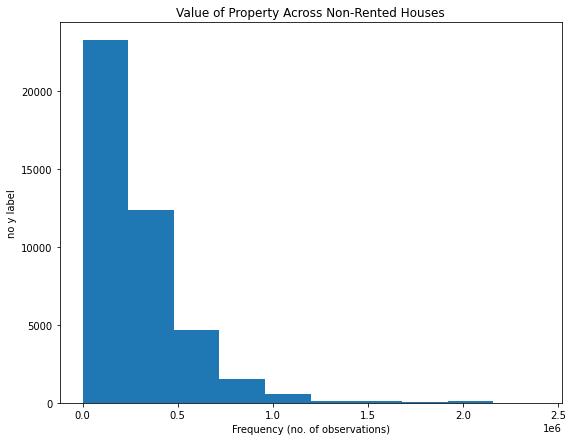

In [118]:

plot_hist_describe(housing["VALP"], "Value of Property Across Non-Rented Houses",  "Frequency (no. of observations)")

* The data above is heavily positively skewed, I thus apply a square root transformation to attempt to make the distribution more symmetric. 

count    42793.000000
mean       484.014457
std        223.687486
min         10.000000
25%        316.227766
50%        447.213595
75%        632.455532
max       1549.193338
Name: VALP, dtype: float64


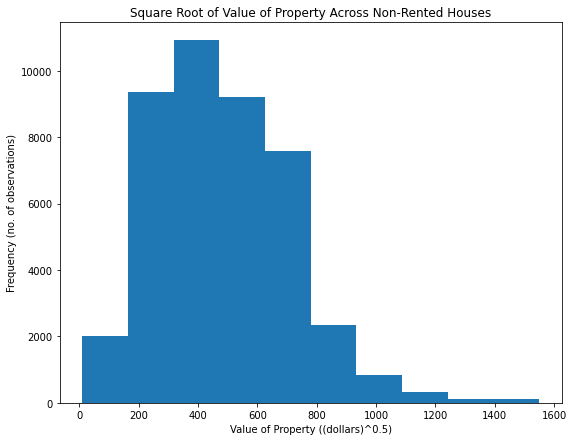

In [119]:
housing_value_sqrt = np.sqrt(housing["VALP"]) 
plot_hist_describe(housing_value_sqrt, "Square Root of Value of Property Across Non-Rented Houses", "Value of Property ((dollars)^0.5)", "Frequency (no. of observations)")


* Although the data is still positively skewed, it is much easier to visualize as the data is more symmetric looking. This can be showed with the skew statistic which will be used from now to demonstrate this. A skew of 0 is a perfect normal distribution. 

In [120]:
print("initial skew", housing["VALP"].skew(), "final skew",housing_value_sqrt.skew()) #normal distribution would have 0 skew

initial skew 2.358658925471289 final skew 0.6540551080981691


* I now explore the other metric of cost which is "GRNTP" Gross monthly rent

count    25621.000000
mean      1158.116467
std        659.626915
min          4.000000
25%        700.000000
50%       1050.000000
75%       1480.000000
max       4380.000000
Name: GRNTP, dtype: float64


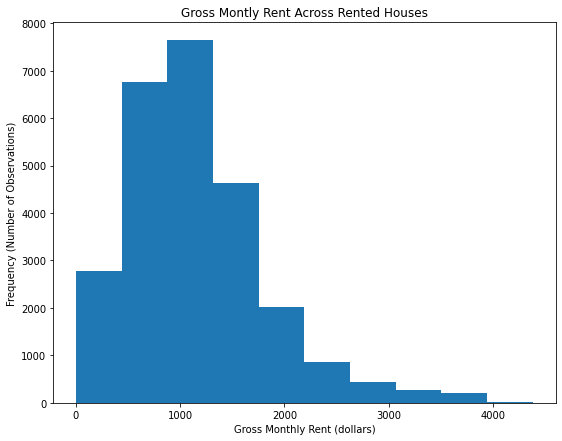

Original skew 1.2245770926216082


In [121]:
gross_rent = housing["GRNTP"]
plot_hist_describe(gross_rent, "Gross Montly Rent Across Rented Houses", "Gross Monthly Rent (dollars)", "Frequency (Number of Observations)" )
print("Original skew", housing['GRNTP'].skew())

* Gross rent is also positively skewed. In order to make the data more normal as well as match the units of squareroot(dollars) of the value of property variable 'VALP', I apply a square root transformation to the values of the 'GRNTP' column. This makes the data more symmetric. 

count    25621.000000
mean        32.685960
std          9.473541
min          2.000000
25%         26.457513
50%         32.403703
75%         38.470768
max         66.181568
Name: GRNTP, dtype: float64


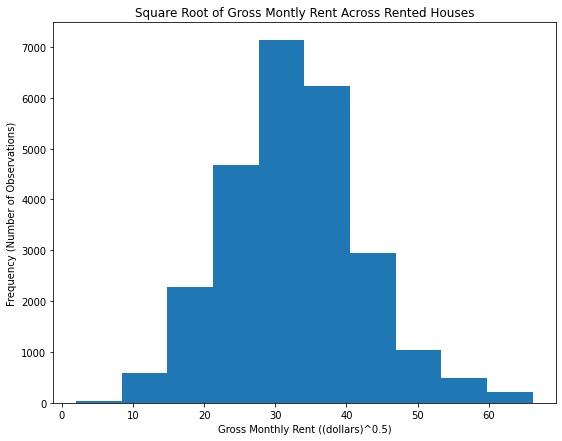

Final skew 0.2988391301332606


In [122]:
gross_rent_sqrt = np.sqrt(gross_rent)
plot_hist_describe(gross_rent_sqrt,"Square Root of Gross Montly Rent Across Rented Houses","Gross Monthly Rent ((dollars)^0.5)", "Frequency (Number of Observations)")
print("Final skew", gross_rent_sqrt.skew())

* The other variable related to cost that might be worthwhile finding relationships with is 'SMOCP' (Selected Monthly Owner Costs). 

count    42793.000000
mean      1468.103078
std       1131.265401
min          0.000000
25%        657.000000
50%       1134.000000
75%       1994.000000
max      11420.000000
Name: SMOCP, dtype: float64


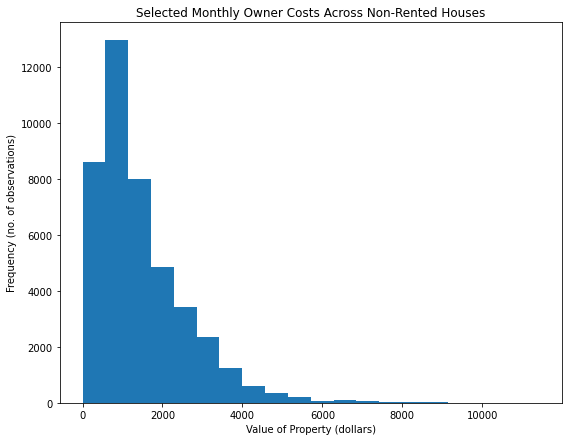

In [123]:
plot_hist_describe(housing["SMOCP"],"Selected Monthly Owner Costs Across Non-Rented Houses", "Value of Property (dollars)",  "Frequency (no. of observations)", bins=20)

* Since this data is also heaviily positively skewed, I will apply a square root transformation. This will also make the units the same as the other cost variables, (dollars)^0.5. 

count    42793.000000
mean        35.760541
std         13.758315
min          0.000000
25%         25.632011
50%         33.674916
75%         44.654227
max        106.864400
Name: SMOCP, dtype: float64


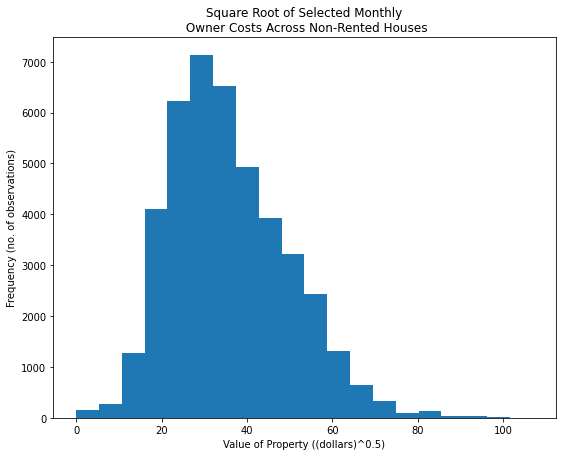

initial skew 1.7103815922585188 final skew 0.6093705487321539


In [124]:
selected_monthly_sqrt = np.sqrt(housing["SMOCP"])
plot_hist_describe(selected_monthly_sqrt,"Square Root of Selected Monthly\n Owner Costs Across Non-Rented Houses","Value of Property ((dollars)^0.5)", "Frequency (no. of observations)", bins=20  )
print("initial skew", housing["SMOCP"].skew(), "final skew",selected_monthly_sqrt.skew()) #normal distribution would have 0 skew

The last variable related to cost that I consider worthwhile including is monthly gross utility bill 'gross_utility'

count    69554.000000
mean       208.703819
std        162.353639
min          2.083333
25%         94.666667
50%        170.333333
75%        282.083333
max       1368.333333
Name: gross_utility, dtype: float64


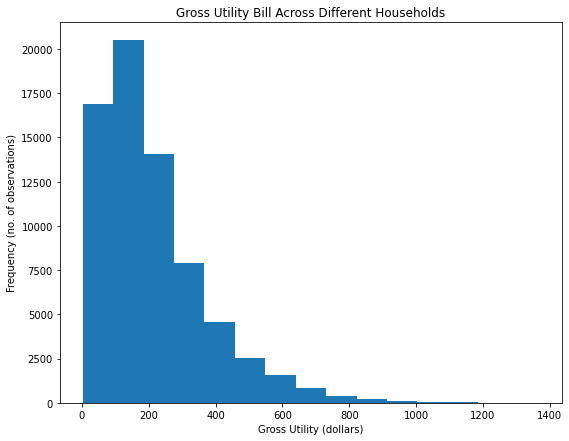

In [125]:
plot_hist_describe(housing["gross_utility"],"Gross Utility Bill Across Different Households", "Gross Utility (dollars)",  "Frequency (no. of observations)", bins=15)

* For the same reasons as the previous variables, I apply a squareroot transformation

count    69554.000000
mean        13.261963
std          5.729277
min          1.443376
25%          9.729680
50%         13.051181
75%         16.795337
max         36.990990
Name: gross_utility, dtype: float64


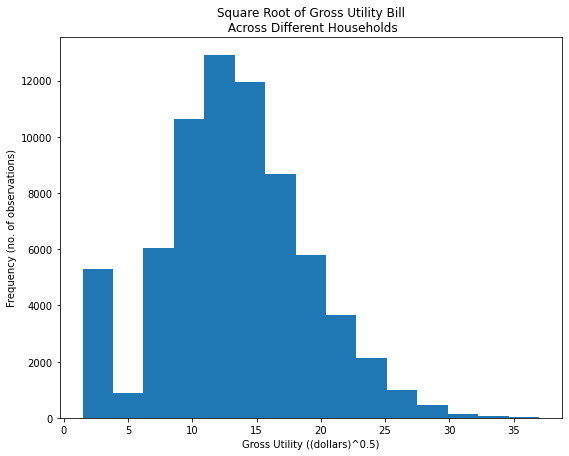

initial skew 1.4345252811550988 final skew 0.09110410671458417


In [126]:
gross_utility_sqrt = np.sqrt(housing["gross_utility"])
plot_hist_describe(gross_utility_sqrt,"Square Root of Gross Utility Bill\n Across Different Households","Gross Utility ((dollars)^0.5)", "Frequency (no. of observations)", bins=15 )
print("initial skew", housing["gross_utility"].skew(), "final skew",gross_utility_sqrt.skew()) #normal distribution would have 0 skew

### Exploring Socio-demographic and Economic Variables

* The Socio-demographic and Economic variables I explore here are: 
  * Total annual income 'HINCP'
  * Householder working and family status 'WKEXREL'
  * Number of persons in household 'NP'
* Here I visualize 'HINCP' (Annual Household Income)

count     69554.000000
mean      66381.562915
std       49698.512432
min       -9000.000000
25%       26500.000000
50%       55000.000000
75%       95600.000000
max      221460.000000
Name: HINCP, dtype: float64


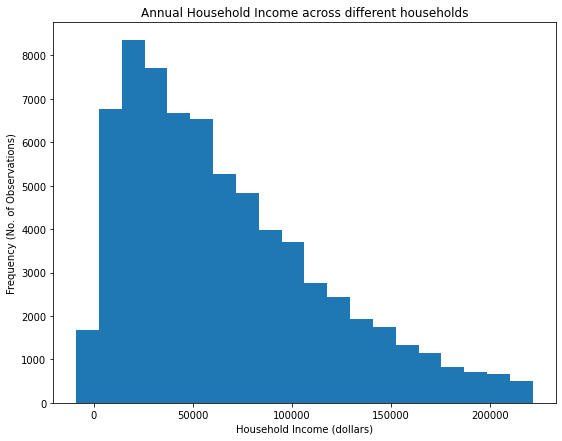

In [127]:
household_income = housing["HINCP"]
plot_hist_describe(household_income, "Annual Household Income across different households", "Household Income (dollars)", "Frequency (No. of Observations)", bins=20)

* To visualize the remaining chosen variable,  work experience of householder and family type (WKEXREL), I use a bar plot with count/frequency on the y-axis and the different categories on the x-axis sorted in decreasing frequency. The categorical numbers correspond as follows: 

1. Householder and spouse worked FT
2. Householder worked FT; spouse worked < FT
3. Householder worked FT; spouse did not work
4. Householder worked < FT; spouse worked FT
5. Householder worked < FT; spouse worked < FT
6. Householder worked < FT; spouse did not work
7. Householder did not work; spouse worked FT
8. Householder did not work; spouse worked < FT
9. Householder did not work; spouse did not work
10. Male householder worked FT; no spouse present
11. Male householder worked < FT; no spouse present
12. Male householder did not work; no spouse present
13. Female householder worked FT; no spouse present
14. Female householder worked < FT; no spouse present
15. Female householder did not work; no spouse present

* 'FT' means fulltime

* The data shows that married and working housholders are the most common among all the different households


count      15.000000
mean     2986.066667
std      1934.651001
min       648.000000
25%      1759.000000
50%      2420.000000
75%      3930.000000
max      7832.000000
Name: WKEXREL, dtype: float64


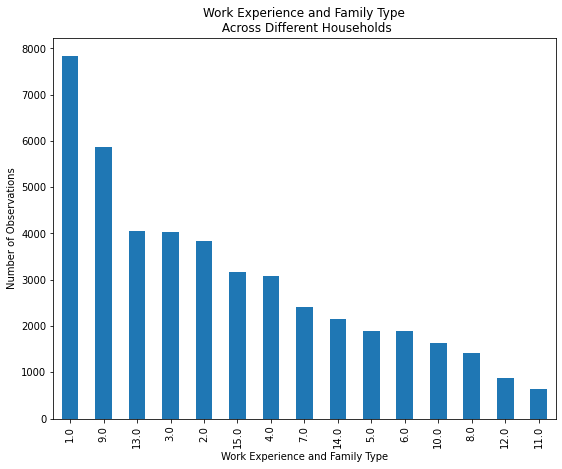

In [128]:
work_experience = housing["WKEXREL"].value_counts()
print(work_experience.describe())
plt.figure(figsize=(9,7))
work_experience.plot.bar()
plt.title("Work Experience and Family Type\n Across Different Households")
plt.xlabel("Work Experience and Family Type")
plt.ylabel("Number of Observations")
plt.show()


## Exploring Corellations and Statistical Differences

#### Exploring Corellations between Continuous Socio-demographic and Economic Characteristics and Housing Expenditure Variables

* In order to visualize any relationship between continuous socio-demographic and economic characteristics and housing expenditure variables, I use scatter plots

In [129]:
'''
Consumes the data to be plotted, width (x), data to be plotted, height (y), title of histogram plot (title), x-axis label (xlabel), 
y-axis label (ylabel) and optional bins passed into plt.hist() method (bins)
'''
def plot_scatter(x, y, title="no title", xlabel = "no x label", ylabel = "no y label"):
  # print(x.describe()) if isinstance(x, (pd.DataFrame, pd.Series)) else 0
  plt.figure(figsize=(9,7))
  plt.scatter(x=x, y=y)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  

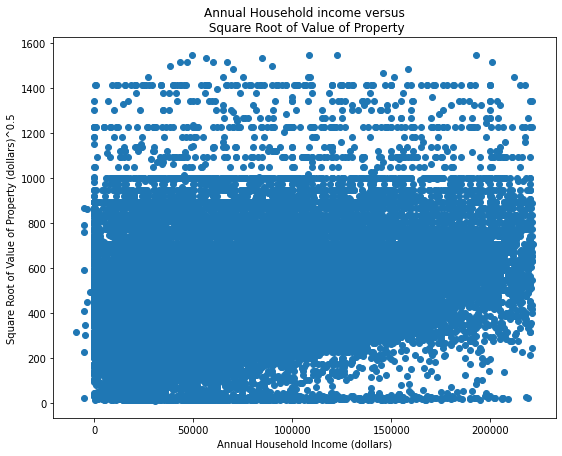

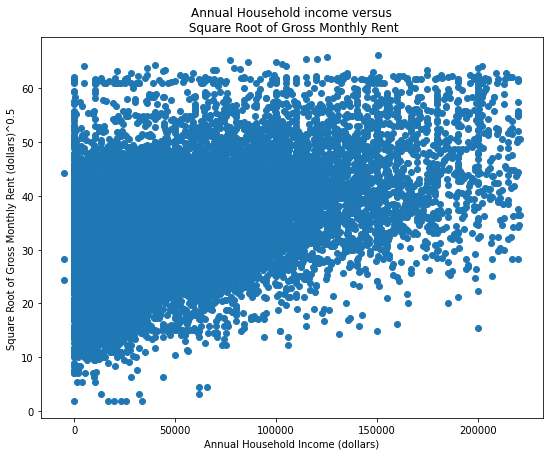

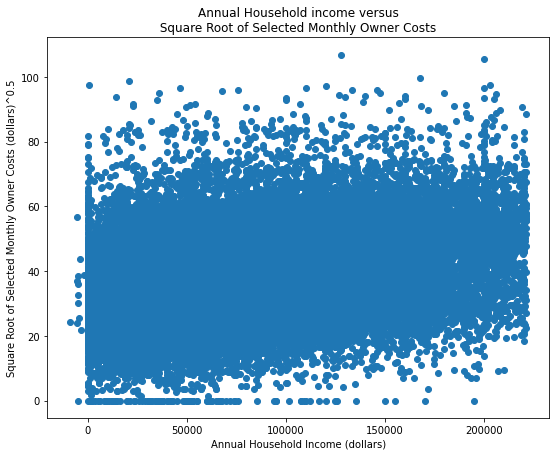

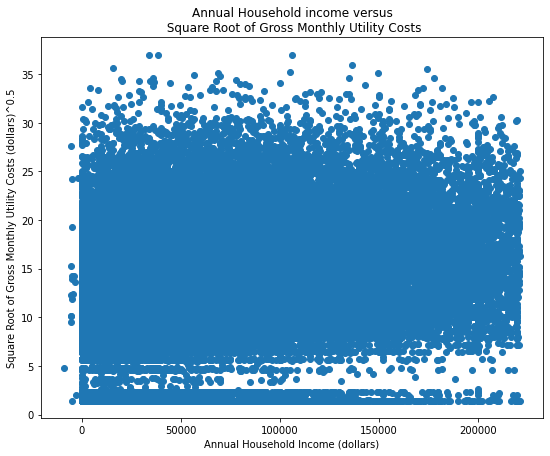

In [130]:
#preliminary scatterplots
plot_scatter(housing["HINCP"], housing_value_sqrt, "Annual Household income versus\n Square Root of Value of Property", "Annual Household Income (dollars)", "Square Root of Value of Property (dollars)^0.5")
plot_scatter(housing["HINCP"], gross_rent_sqrt, "Annual Household income versus\n Square Root of Gross Monthly Rent", "Annual Household Income (dollars)", "Square Root of Gross Monthly Rent (dollars)^0.5")
plot_scatter(housing["HINCP"], selected_monthly_sqrt, "Annual Household income versus\n Square Root of Selected Monthly Owner Costs ", "Annual Household Income (dollars)", "Square Root of Selected Monthly Owner Costs (dollars)^0.5")
plot_scatter(housing["HINCP"], gross_utility_sqrt, "Annual Household income versus\n Square Root of Gross Monthly Utility Costs", "Annual Household Income (dollars)", "Square Root of Gross Monthly Utility Costs (dollars)^0.5")


* From a preliminary standpoint, although none of them have a clear corellation, annual monthly income and square root of gross monthly rent seems to have a positive corellation, followed by annual monthly income and square root of selected monthly owner costs. 
* Annual income and squareroot of property value, and annual income and annual gross utility seem to have a very weak positive corellation, which I had not expected.
* In order to validate these seeming positive corellations between socio-demographic and economic characteristics and housing expense variables, I use a Pearson Corellation Coefficient to test linear corellations. 
* Since the data is a lot, I can use Pearson corellation coefficient without having to have a normal distribution in the variates
* I run the corellation on only small samples of the data from the distribution. This allows you to see the p_value as a non zero value. 


In [131]:
test_statistic, p_value = stats.pearsonr(housing[~(housing["VALP"].isna())]["HINCP"][:5000], housing_value_sqrt.dropna()[:5000])
print("test_statistic", test_statistic, "p value:", p_value)

test_statistic 0.31167781959646823 p value: 4.464159033728769e-113


* Therefore the two variables are linearly corellated, as we can reject the null hypothesis that the two variables are not corellated since p < alpha where alpha = 0.05
* The positive corellation coeffecient of 0.312 shows that when annual household income increases, the square root of value of property increases. 
* I repreat the same procedure for the rest of the relationships aforementioned. 

I proceed to check for a linear relationship between annual income and the squareroot of selected monthly ownership costs 


In [132]:
test_statistic, p_value = stats.pearsonr(housing[~(housing["SMOCP"].isna())]["HINCP"][:5000], selected_monthly_sqrt.dropna()[:5000])
print("test_statistic", test_statistic, "p value:", p_value)

test_statistic 0.4388377815993059 p value: 1.7922311796646798e-234


* We can reject the null hypothesis that the two variables are not corellated since p-value < 0.05
* There is thus a positive linear corellation between annual houshold income and the square root of selected monthly owner costs
* The Pearson's Corellation Coeffecient of 0.4389 indicates that there is a stronger positive corellation between annual income and square root of selected monthly owner costs than annual income and square root of value of property

Now I proceed to check Pearson's Corellation Coefficient between annual income and value of property

In [133]:
test_statistic, p_value = stats.pearsonr(housing[~(housing["GRNTP"].isna())]["HINCP"][:4000], gross_rent_sqrt.dropna()[:4000])
print("test_statistic", test_statistic, "p value:", p_value)

test_statistic 0.5059252463968238 p value: 5.213721807723562e-259


* We can reject the null hypothesis that the two variables are not corellated since p-value < 0.05
* There is thus a positive linear corellation between annual houshold income and the square root of gross monthly income
* This result is just as to be expected as it matches the scatterplot visualisation and the comment I made earlier about which graphs indicates a greater positive corellation. 
* A Pearson corellation coeffecient of 0.5 indicates quite strong corellation between annual household income and square root of gross monthly income

Lastly I check Pearson corellation coeffecient between annual income and the square root gross monthly utility cost 

In [134]:
test_statistic, p_value = stats.pearsonr(housing[~(housing["gross_utility"].isna())]["HINCP"][:5000], gross_utility_sqrt.dropna()[:5000])
print("test_statistic", test_statistic, "p value:", p_value)

test_statistic 0.27484035355505654 p value: 2.344608338850315e-87


* We can reject the null hypothesis that the two variables are not corellated since p-value < 0.05
* As expected, there seems to be a weak positive corellation between annual income and square root monthly gross utility. 

There is thus linear positive corellations established between the following pairs of variables in order of highest Pearson corellation coefficient: 

1. Annual houshold income and the squareroot of gross monthly income (r = 0.5059)
2. Annual houshold income and the square root of selected monthly owner costs (r = 0.4389)
3. Annual household income and the square root of value of property (r = 0.3116)
4. Annual income and square root of gross monthly utility cost (r = 0.2748)

* We can reject the null hypothesis that the two variables are not corellated since p-value < 0.05
* As expected, there seems to be a weak positive corellation between annual income and squareroot annual gross utility. 

* I now proceed to explore statistical differences between the variable work experience and family kind and all the housing expense variables: Value of Property (VALP), gross rent paid per month (GRNTP) and lastly selected monthly ownership costs (SMOCP).
* I first plot box plots to visualize the different variables

In [135]:
box_rent = pd.concat([housing["WKEXREL"], gross_rent_sqrt], axis=1)
box_value = pd.concat([housing["WKEXREL"], housing_value_sqrt], axis=1)
box_selected = pd.concat([housing["WKEXREL"], selected_monthly_sqrt], axis=1)
box_utility = pd.concat([housing["WKEXREL"], gross_utility_sqrt], axis=1)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


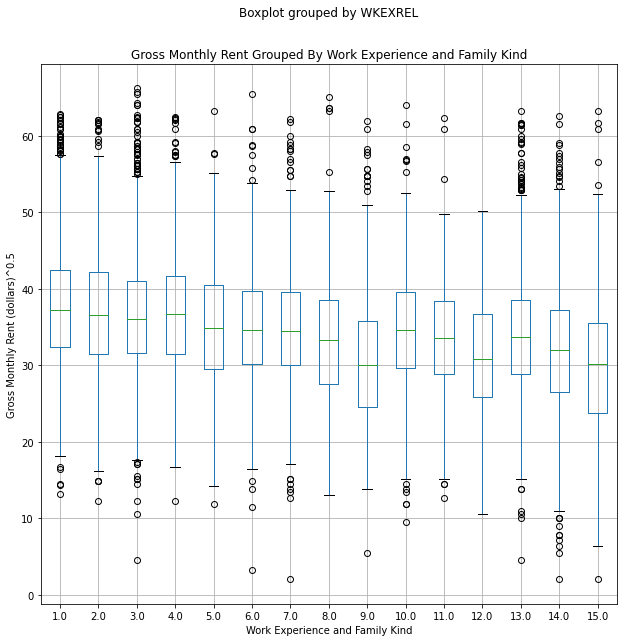

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


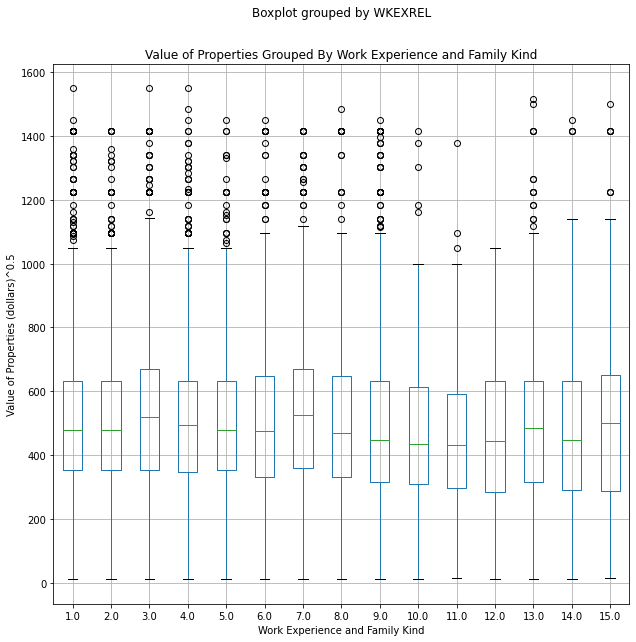

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


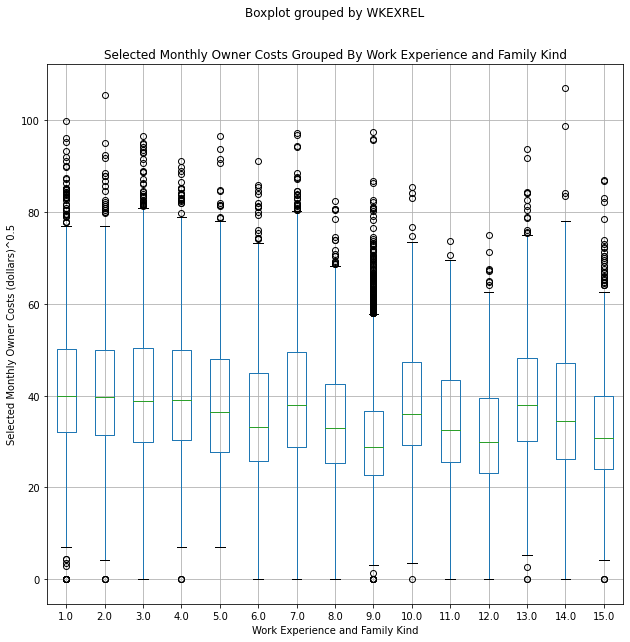

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


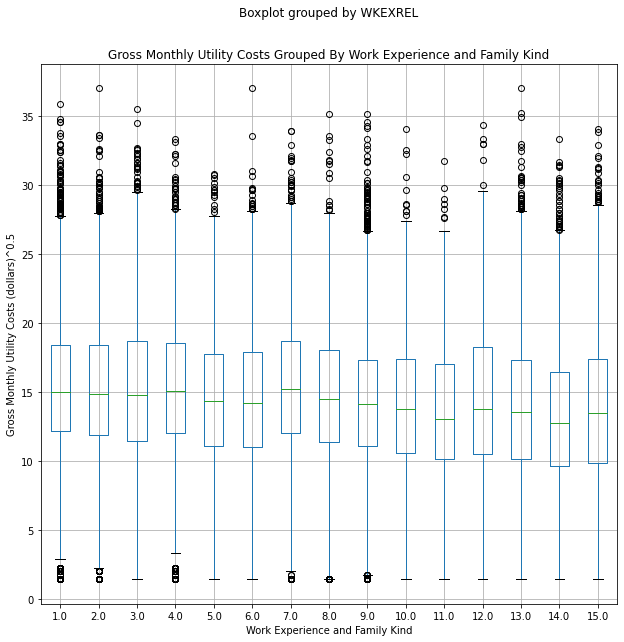

In [136]:
box_rent.boxplot(by="WKEXREL", figsize=(10,10))
plt.title("Gross Monthly Rent Grouped By Work Experience and Family Kind")
plt.xlabel("Work Experience and Family Kind")
plt.ylabel("Gross Monthly Rent (dollars)^0.5")
plt.show()
box_value.boxplot(by="WKEXREL", figsize=(10,10))
plt.title("Value of Properties Grouped By Work Experience and Family Kind")
plt.xlabel("Work Experience and Family Kind")
plt.ylabel("Value of Properties (dollars)^0.5")
plt.show()

box_selected.boxplot(by="WKEXREL", figsize=(10,10))
plt.title("Selected Monthly Owner Costs Grouped By Work Experience and Family Kind")
plt.xlabel("Work Experience and Family Kind")
plt.ylabel("Selected Monthly Owner Costs (dollars)^0.5")
plt.show()

box_utility.boxplot(by="WKEXREL", figsize=(10,10))
plt.title("Gross Monthly Utility Costs Grouped By Work Experience and Family Kind")
plt.xlabel("Work Experience and Family Kind")
plt.ylabel("Gross Monthly Utility Costs (dollars)^0.5")
plt.show()


* The Kruskal-Wallis H-test is the non-parametric equivalent of the ANOVA test. It tests the median of 2 or more independent variables for statistical difference. The null hypothesis is that the median of the random populations are the same.
* The results show that each of the medians of the monthly housing expenditure variables grouped by Work Experience and Family Kind 'WKEXREL.' are statistically different. 

In [137]:
# Work Experience and Family Types and square root monthly gross rent
box_rent_agg = []
for i in range(len(housing["WKEXREL"].unique())-1): 
  box_rent_agg.append(box_rent[box_rent["WKEXREL"] == float(i+1)]["GRNTP"].dropna().tolist())
print(stats.kruskal(*box_rent_agg))

# Work Experience and Family Types and square root value of property
box_value_agg = []
for i in range(len(housing["WKEXREL"].unique())-1): 
  box_value_agg.append(box_value[box_value["WKEXREL"] == float(i+1)]["VALP"].dropna().tolist())
print(stats.kruskal(*box_value_agg))
# Work Experience and Family Types and square root selected monthly ownership costs
box_selected_agg = []
for i in range(len(housing["WKEXREL"].unique())-1): 
  box_selected_agg.append(box_selected[box_selected["WKEXREL"] == float(i+1)]["SMOCP"].dropna().tolist())
print(stats.kruskal(*box_selected_agg))
# Work Experience and Family Types and square root gross utility costs
box_utility_agg = []
for i in range(len(housing["WKEXREL"].unique())-1): 
  box_utility_agg.append(box_utility[box_utility["WKEXREL"] == float(i+1)]["gross_utility"].dropna().tolist())
print(stats.kruskal(*box_utility_agg))


KruskalResult(statistic=1249.2530676991262, pvalue=4.453672461848682e-258)
KruskalResult(statistic=196.79428461045254, pvalue=2.4788605640560734e-34)
KruskalResult(statistic=2779.930928026513, pvalue=0.0)
KruskalResult(statistic=837.2584114652822, pvalue=1.1790845883391584e-169)


* For each of those results, we can reject the null hypothesis that the population median of all of the groups are equal which means there are statistical differences of the median in each of the tested distributions. Because for each of them, the p value returned is liess than 0.05
* This, however, does not tell us which groups in specific are statistically different and more testing would be required to narrow down. 

## Conclusion

There was found to be positive linear corellation between socio-demographic and economic characterstics of households in New York and housing expenditure per household. Furthermore, statistical difference is found between the medians of housing expenditure variates when grouped by work experience and family type. This is indicative of work experience and family type playing a role in staratifying the different levels of household housing expenditure. 
In applying it to the the context of the problem of housing affordability, it is significant to note that those who rent are most subject to housing expenses that depend on their monthly household income. Compared to homeowners who buy homes in a manner that is more invariant to their monthly household income. 

An improvement study can be carried out to include more demographic variables such as gender, age and race to see how it would segment housing expenditure even further. 